# Load modules

In [1]:
# import all modules
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from PyPRIS import *
from PyPRIS.PRIS import * 
from PyPRIS.module_observe_station import *
import copy
import time

In [2]:
%load_ext autoreload
%autoreload 2

# Construct obseration operator (load PSF)

In [3]:
# construct observation operator.
 # load psf matrix
dpath = './test_data/psf.tif';
psf = io.imread(dpath)

# Observation preparation

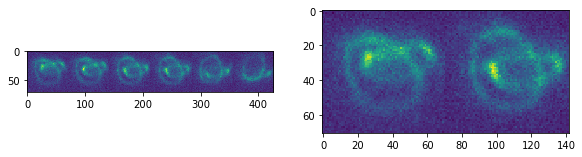

In [4]:
# load observation
data_path = './test_data';
f = 'obsStack.tif';
fov = io.imread(data_path + '/' + f)
fov.shape
plt.figure(figsize=(15,5));
plt.subplot(131)
plt.imshow(fov[[1,3,5,6,10,15],:,:].reshape(6*fov.shape[1],fov.shape[2]).T)

# choose the blur
blur1 = fov[1,:,:];
blur2 = fov[6,:,:];
#100 nm step interval so there is a 500 nm separation. 20 layer separation between psf steps.
blur = np.concatenate([blur1, blur2]).reshape(2*71,71);
plt.subplot(132)
plt.imshow(blur.T)

# prepare a observer for pypris. [from one candidate, to one observation]
#  #  summon an observer from the ObserveStation (ObserveStation class) (Cheers~)
observer = ObserveStation()

#  #  configure this observer with biplane observation specifics
observer.observe_biplane_prep(psf, single_image_size = blur1.shape, \
                           deltaz_plane1 = -10, \
                           deltaz_plane2 = 10, \
                           psfz0 = 106, \
                           observer_debugger = False, \
                           observer_edge_padding = True)
# this observer will perform observation for the pypris object as seen below in the next section titled 'Initialize PyPRIS'.

# Initialize PyPRIS

In [5]:
%reload_ext autoreload

In [6]:
# get a PyPRIS object:
pypris = PyPRIS()
pypris.observation = blur.ravel()
pypris.current_candidates_intervals = list([1, 4, 4])  # initialize the first intervals of neighboring candidate voxels.

# decide candidates for the first PRIS iteration. PRIS #0:
range_ind0 = np.arange(-36, 36, pypris.current_candidates_intervals[0]) # seems like for DH psf, use finnest intervals for the thickness dimension is better.
range_ind1 = np.arange(5,   66, pypris.current_candidates_intervals[1])
range_ind2 = np.arange(5,   66, pypris.current_candidates_intervals[2])

# initialize the first pool of candidates with the current candidate intervals.
pypris.current_candidates = list()  # current pool of candidates.
for i0 in range_ind0:
    for i1 in range_ind1:
        for i2 in range_ind2:
            pypris.current_candidates.append([i0,i1,i2])

# set a check mark for pypris:
pypris.set_check_mark()

# put the configured observer to the pypris to perform the tasks of 'observe_biplane'
# when a pypris object observes, it is through the observer and it is 
# done with the observer's observe_biplane skill (skill = method).
pypris.observe = observer.observe_biplane
#pypris.show_attributes()

# Prepare an origin LinBreg object

In [7]:
%reload_ext autoreload

In [8]:
# condition a main linbreg object that carries the basic configurations. 
# for each PRIS iteration, a new linbreg object will be cloned from this one for its own task.
# the purpose here is just to simplify the parameter configuration process.

linbreg_ori = LinBreg(None)
linbreg_ori.debug = True
linbreg_ori.deep_debug = False
linbreg_ori.mu = 1000000000
linbreg_ori.obs_dim0 = blur.shape[0]
linbreg_ori.obs_dim1 = blur.shape[1]
linbreg_ori.alpha = 1e-8
linbreg_ori.maxit = 200
linbreg_ori.it_check_rem = 1
linbreg_ori.debug_it_int = 100
linbreg_ori.kick.ints = 10
linbreg_ori.kick.flag = True
linbreg_ori.kick.thres = 1e-3
linbreg_ori.save_obj_int = 100
linbreg_ori.save = True

# PRIS iteration # 0

In [9]:
%reload_ext autoreload

In [10]:
# construct sensing matrix,

pypris.generate_sensing_mx() 

# prepare the inner sparse recovery
pypris.current_A[:,len(pypris.current_candidates)] = 550
Anorm = pypris.current_A/500
linbreg = copy.deepcopy(linbreg_ori)
linbreg.candidate_coords = pypris.current_candidates
linbreg.candidate_intervals = pypris.current_candidates_intervals
linbreg.A = Anorm
linbreg.b = pypris.observation.ravel()
linbreg.PyPRIS_iter = 0

# recover
linbreg.get_ready()
linbreg.go()


stopping threshold is -11
alpha is 1e-08
Successfully created Scratch directory ../PyPRIS_Scratch 
Successfully wrote sensing matrix to directory ../PyPRIS_Scratch/saved_objects 
Successfully created Object-saving directory ../PyPRIS_Scratch/saved_objects 
Successfully created Debug directory ../PyPRIS_Scratch/debug_output 


G:\DH_localization\PyPRIS\PyPRIS\PRIS.py:491: RuntimeWarning: divide by zero encountered in double_scalars
  /self.hist_res[it_count - 1] \
G:\DH_localization\PyPRIS\PyPRIS\PRIS.py:439: RuntimeWarning: divide by zero encountered in log
  plt.plot(self.iterations, abs(np.log(abs(np.asarray(self.hist_res)))) \
G:\DH_localization\PyPRIS\PyPRIS\PRIS.py:440: RuntimeWarning: invalid value encountered in multiply
  *np.sign(self.hist_res), \


intermediate output it#1


G:\DH_localization\PyPRIS\PyPRIS\PRIS.py:446: RuntimeWarning: divide by zero encountered in log
  plt.plot(self.iterations, abs(np.log(abs(np.asarray(self.hist_delta_res)))) \
G:\DH_localization\PyPRIS\PyPRIS\PRIS.py:447: RuntimeWarning: invalid value encountered in multiply
  *np.sign(self.hist_delta_res), \
G:\DH_localization\PyPRIS\PyPRIS\PRIS.py:453: RuntimeWarning: divide by zero encountered in log
  plt.plot(self.iterations, abs(np.log(abs(np.asarray(self.hist_percent_delta_res)))) \
G:\DH_localization\PyPRIS\PyPRIS\PRIS.py:454: RuntimeWarning: invalid value encountered in multiply
  *np.sign(self.hist_percent_delta_res), \


Successfully saved Linbreg ID 0 at iteration 1 to directory.


G:\DH_localization\PyPRIS\PyPRIS\PRIS.py:496: RuntimeWarning: divide by zero encountered in log
  self.stopping_loghistpercdelres = abs(np.log(abs(stopping_tag)))*np.sign(stopping_tag)
G:\DH_localization\PyPRIS\PyPRIS\PRIS.py:496: RuntimeWarning: invalid value encountered in double_scalars
  self.stopping_loghistpercdelres = abs(np.log(abs(stopping_tag)))*np.sign(stopping_tag)


intermediate output it#101
Successfully saved Linbreg ID 0 at iteration 101 to directory.
intermediate output it#200
Successfully saved Linbreg ID 0 at iteration 200 to directory.


# PRIS iteration 1 and on

In [11]:
# construct sensing matrix,
pypris.prep_for_new_refinement()
pypris.refine_candidates(linbreg)
pypris.generate_sensing_mx() 

# prepare the inner sparse recovery
pypris.current_A[:,len(pypris.current_candidates)] = 550
Anorm = pypris.current_A/500
del linbreg
linbreg_ori.A = 0
linbreg = copy.deepcopy(linbreg_ori)
linbreg.candidate_coords = pypris.current_candidates
linbreg.candidate_intervals = pypris.current_candidates_intervals
linbreg.A = Anorm
linbreg.b = pypris.observation.ravel()
linbreg.PyPRIS_iter = 1 
# recover
linbreg.get_ready()
linbreg.go()

stopping threshold is -11
alpha is 1e-08
Successfully created Scratch directory ../PyPRIS_Scratch 
Successfully wrote sensing matrix to directory ../PyPRIS_Scratch/saved_objects 
Successfully created Object-saving directory ../PyPRIS_Scratch/saved_objects 
Successfully created Debug directory ../PyPRIS_Scratch/debug_output 
intermediate output it#1
Successfully saved Linbreg ID 1 at iteration 1 to directory.
intermediate output it#101
Successfully saved Linbreg ID 1 at iteration 101 to directory.
intermediate output it#200
Successfully saved Linbreg ID 1 at iteration 200 to directory.


In [12]:
pypris_old = copy.deepcopy(pypris)

In [13]:
%reload_ext autoreload

In [14]:
pypris = copy.deepcopy(pypris_old)
pypris.prep_for_new_refinement()
pypris.refine_candidates(linbreg)

In [15]:
# construct sensing matrix,
pypris.observe = observer.observe_biplane
pypris.generate_sensing_mx() 

In [16]:
# prepare the inner sparse recovery
pypris.current_A[:,len(pypris.current_candidates)] = 550
Anorm = pypris.current_A/500
del linbreg
linbreg_ori.A = 0
linbreg = copy.deepcopy(linbreg_ori)
linbreg.candidate_coords = pypris.current_candidates
linbreg.candidate_intervals = pypris.current_candidates_intervals
linbreg.A = Anorm
linbreg.b = pypris.observation.ravel()
linbreg.PyPRIS_iter = 2
# recover
linbreg.get_ready()
linbreg.go()

stopping threshold is -11
alpha is 1e-08
Successfully created Scratch directory ../PyPRIS_Scratch 
Successfully wrote sensing matrix to directory ../PyPRIS_Scratch/saved_objects 
Successfully created Object-saving directory ../PyPRIS_Scratch/saved_objects 
Successfully created Debug directory ../PyPRIS_Scratch/debug_output 
intermediate output it#1
Successfully saved Linbreg ID 2 at iteration 1 to directory.
intermediate output it#101
Successfully saved Linbreg ID 2 at iteration 101 to directory.
intermediate output it#200
Successfully saved Linbreg ID 2 at iteration 200 to directory.
